<a href="https://colab.research.google.com/github/jeremysong45/Pump-Performance-Models/blob/main/Linear_Regression_model_for_pump_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install -q sklearn
clear_output()

In [43]:
%tensorflow_version 2.x
clear_output()

In [44]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [45]:
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [46]:
import pandas as pd
import sqlite3

SQLname = "/content/drive/MyDrive/ESP/ESP.db"


conn = sqlite3.connect(SQLname)



query1 = "SELECT * FROM df_Viscosity;"
data = pd.read_sql_query(query1, conn)


# Selecting 4 columns only
query2 = (
    "SELECT QL_bpd, RPM, TargetVISL_cp, Head_ft "
    "FROM df_viscosity "
    "WHERE Pump LIKE 'P100%' "
    "ORDER BY RPM, TargetVISL_cp;"
)
df_data = pd.read_sql_query(query2, conn)

conn.close()

df_data.head()


,QL_bpd,RPM,TargetVISL_cp,Head_ft
0,639.156,2400,10.0,26.228784
1,1273.992,2400,10.0,26.124187
2,1910.466,2400,10.0,25.782991
3,2543.340,2400,10.0,25.235809
4,3180.630,2400,10.0,24.610803


In [47]:
train_dataset = df_data.sample(frac=0.7, random_state=0)
test_dataset = df_data.drop(train_dataset.index)

print("Train dataset shape:", train_dataset.shape)
print("Test dataset shape:", test_dataset.shape)

y_train = train_dataset.pop("Head_ft")
y_test = test_dataset.pop("Head_ft")

Train dataset shape: (273, 4)
Test dataset shape: (117, 4)


In [48]:
NUMERIC_COLUMNS = ["QL_bpd", "RPM", "TargetVISL_cp"]
feature_columns = []

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

clear_output()

print(feature_columns)

[NumericColumn(key='QL_bpd', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='RPM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='TargetVISL_cp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [49]:
def make_input_fn(data_df, label_df, num_epochs=1000, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(train_dataset, y_train)
eval_input_fn = make_input_fn(test_dataset, y_test, num_epochs=1, shuffle=False)

In [50]:
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()

print(result)

{'average_loss': 22.451822, 'label/mean': 34.36778, 'loss': 23.147667, 'prediction/mean': 35.14453, 'global_step': 9000}


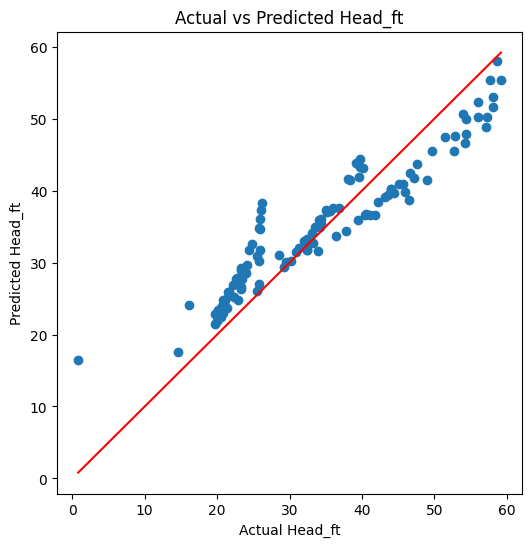

In [51]:
predictions = linear_est.predict(eval_input_fn)
predicted_values = [pred['predictions'][0] for pred in predictions]


plt.figure(figsize=(6, 6))
plt.scatter(y_test, predicted_values)
plt.xlabel('Actual Head_ft')
plt.ylabel('Predicted Head_ft')
plt.title('Actual vs Predicted Head_ft')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
clear_output()
plt.show()

Counts: [ 9 23  6 19 28 23  3  3  2  1]
Bins: [-8.24306476 -5.85499087 -3.46691698 -1.07884309  1.3092308   3.69730468
  6.08537857  8.47345246 10.86152635 13.24960024 15.63767413]


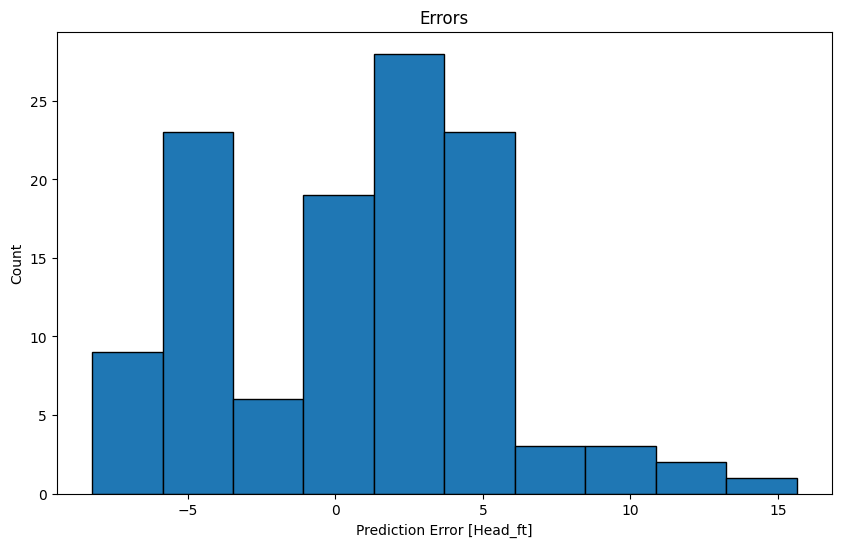

In [52]:
error = predicted_values - y_test


counts, bins = np.histogram(error, bins=10)


print("Counts:", counts)
print("Bins:", bins)

plt.figure(figsize=(10, 6))
plt.hist(error, bins=10, edgecolor='black')
plt.xlabel("Prediction Error [Head_ft]")
plt.ylabel("Count")
plt.title("Errors")
plt.show()

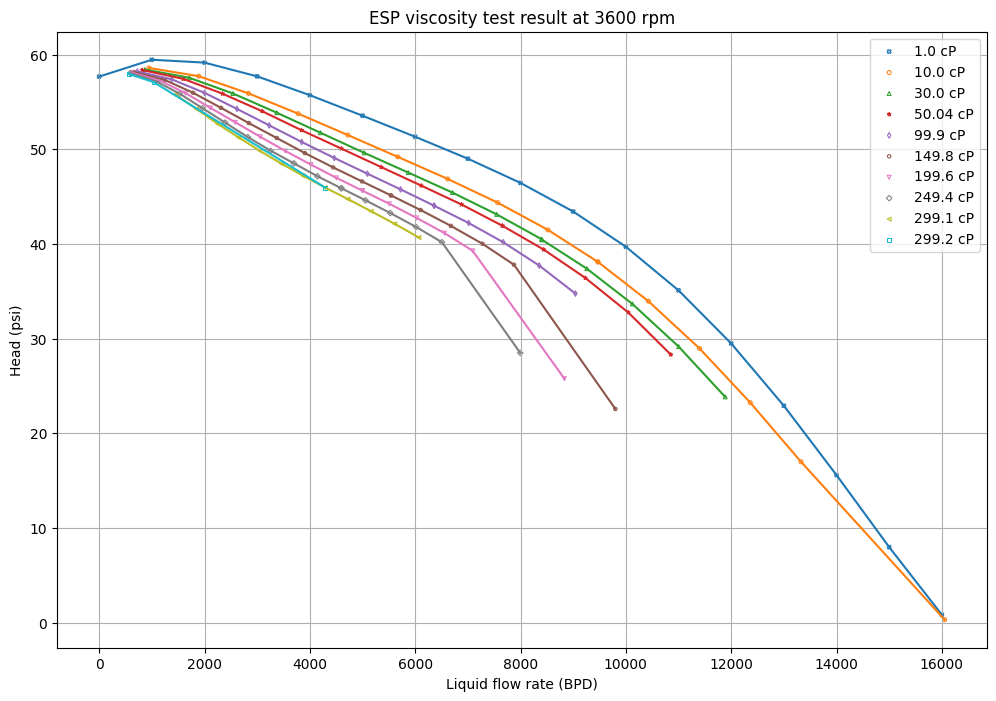

In [53]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
          '#acc2d9', '#56ae57','#b2996e','#a8ff04','#69d84f','#894585',
          '#65ab7c','#952e8f','#fcfc81','#a5a391']
symbols = ['X', 'o', '^', '*', 'd', 'p', 'v', 'D', '<', 's',
           '>', '*', 'h', '1', 'p', '2', '8', 'd', '_', 'X']

icon = 0
unique_viscosities = sorted(df_data['TargetVISL_cp'].unique())
fig5, ax5 = plt.subplots(figsize=(12, 8))

for viscosity in unique_viscosities:
    subset = df_data[(df_data['TargetVISL_cp'] == viscosity) & (df_data['RPM'] == 3600)]
    if not subset.empty:
        ax5.scatter(subset['QL_bpd'], subset['Head_ft'], label=f'{viscosity} cP', facecolor='none', edgecolor=colors[icon], marker=symbols[icon], linewidths=0.75, s=8)
        ax5.plot(subset['QL_bpd'], subset['Head_ft'], color=colors[icon])
        icon += 1

ax5.set_xlabel('Liquid flow rate (BPD)')
ax5.set_ylabel('Head (psi)')
ax5.set_title('ESP viscosity test result at 3600 rpm')
ax5.legend()
ax5.grid(True)
plt.show()